In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### Data preparation

The dataframe has no headers, so, first of all, I'll add column names:

In [2]:
columns = ['Order_date', 'Order_ID', 'Purchased_product_ID', 'Quantity_of_SKU_in_the_order', 'Category_ID', 'Category_alias', 'Brand_ID', 'Price', 'User_ID', 'Product_gender', 'Colour', 'Metal', 'Gem']

In [3]:
df = pd.read_csv('jewelry.csv', names=columns)

Then, I'll check basic information on the content of the dataframe: the presence of null values, the types of the variables, and do all the necessary transformations:

In [4]:
df.head(4)

,Order_date,Order_ID,Purchased_product_ID,Quantity_of_SKU_in_the_order,Category_ID,Category_alias,Brand_ID,Price,User_ID,Product_gender,Colour,Metal,Gem
0,2018-12-01 11:40:29 UTC,1924719191579951782,1842195256808833386,1,1.806829e+18,jewelry.earring,0.0,561.51,1.515916e+18,NaN,red,gold,diamond
1,2018-12-01 17:38:31 UTC,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
2,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
3,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond


In [5]:
df.isnull().sum().sort_values()

Order_date                          0
Order_ID                            0
Purchased_product_ID                0
Quantity_of_SKU_in_the_order        0
Brand_ID                         4785
Category_ID                      5352
Price                            5352
User_ID                          5352
Metal                            5462
Colour                           7660
Category_alias                   9933
Gem                             34058
Product_gender                  48168
dtype: int64

→ Most missing values are in columns with additional information about the order, such as jewelry colour or category, which is not essential for the analysis. But there are 5352 rows with no user ID and item price. I'll remove it for the datafame:

In [6]:
df = df[df['User_ID'].notnull()]

In [7]:
df.dtypes

Order_date                       object
Order_ID                          int64
Purchased_product_ID              int64
Quantity_of_SKU_in_the_order      int64
Category_ID                     float64
Category_alias                   object
Brand_ID                        float64
Price                           float64
User_ID                         float64
Product_gender                   object
Colour                           object
Metal                            object
Gem                              object
dtype: object

In [8]:
df['Order_date'] = df['Order_date'].apply(lambda x: x.replace(' UTC', ''))

In [9]:
df['Order_date'] = df['Order_date'].apply(pd.to_datetime)

In [10]:
df['Month_of_order'] = df['Order_date'].map(lambda x: x.strftime('%Y-%m'))

Then, I'll I will take a closer look at some columns:

In [11]:
df['Order_date'].min()

Timestamp('2018-12-01 11:40:29')

In [12]:
df['Order_date'].max()

Timestamp('2021-12-01 09:59:07')

→ Data for December 2021 is incomplete, so I'll remove this month from the dataframe:

In [13]:
df = df.loc[df['Month_of_order'] != '2021-12']

In [14]:
df['Price'].min()

0.99

In [15]:
df['Price'].max()

34448.6

→ There is nothing unusual with price, so I'll leave this column unchanged.

### Answering Some Questions About Data

__1. How many orders and for what amount do customers place each month?__

In [16]:
orders = df.groupby(['User_ID', 'Month_of_order']).agg({'Order_ID':'count', 'Price':'sum'}) \
.rename(columns={'Order_ID':'Orders', 'Price':'Revenue'})

In [17]:
orders_by_month = orders.groupby('Month_of_order').agg({'Orders':'sum', 'Revenue':'sum'}).reset_index()

In [18]:
orders_by_month.head()

,Month_of_order,Orders,Revenue
0,2018-12,122,33935.77
1,2019-01,566,191471.91
2,2019-02,779,240286.89
3,2019-03,636,216889.54
4,2019-04,673,229081.68


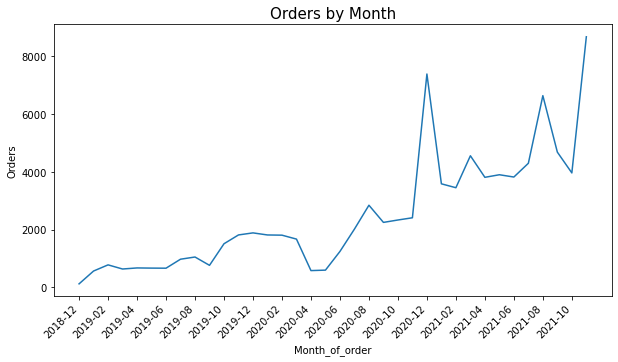

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=orders_by_month, x='Month_of_order',y='Orders')
plt.xticks(
    orders_by_month['Month_of_order'].iloc[::2],
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Orders by Month", fontsize = 15);

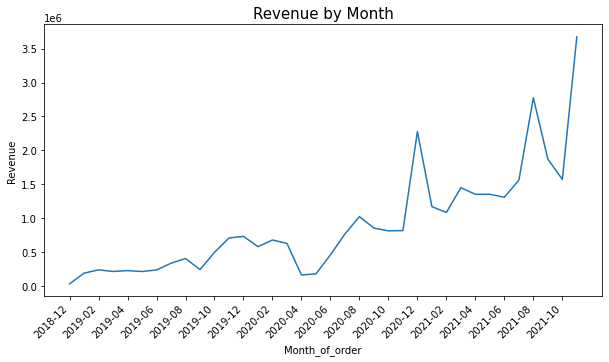

In [20]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=orders_by_month, x='Month_of_order',y='Revenue')
plt.xticks(
    orders_by_month['Month_of_order'].iloc[::2],
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Revenue by Month", fontsize = 15);

Then, I'll check the difference between the first month in the dataframe and the last one:

In [21]:
diff_between_first_and_last_months = orders_by_month.query("Month_of_order in ['2018-12', '2021-11']")[['Orders', 'Revenue']].pct_change()
diff_between_first_and_last_months

,Orders,Revenue
0,NaN,NaN
35,70.090164,107.281834


→ Despite seasonal sales fluctuations, number of orders and revenue have grown steadily over the three years. Sales volume has increased by 70% and sales revenue has increased by 107%, compared with December 2018.

__2. AOV, PF, ARPU by years__

Answering on these questions, I won't look at 2018 as I don't have complete data for that year to trace the tendency.

In [22]:
df_for_metrics = df[df['Month_of_order'] != '2018-12']

How has the average order value changed over a given period?

In [23]:
AOV = df_for_metrics.groupby([df_for_metrics['Order_date'].dt.year, 'Order_ID']).agg({'Price':'mean'}).reset_index()
AOV = AOV.groupby('Order_date').agg({'Price':'mean'}).rename(columns={'Price':'AOV'}).reset_index()
AOV

,Order_date,AOV
0,2019,354.772958
1,2020,338.844893
2,2021,371.962621


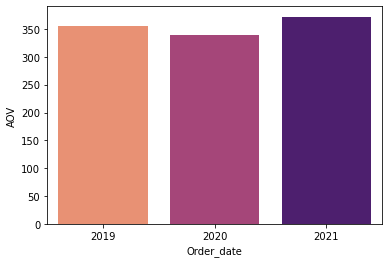

In [24]:
sns.barplot(data=AOV, x='Order_date', y='AOV', palette='magma_r');

How has the average purchase frequency changed?

In [25]:
PF = df_for_metrics.groupby(df_for_metrics['Order_date'].dt.year).agg({'User_ID':'nunique', 'Order_ID':'count'}).reset_index()
PF['PF'] = PF['Order_ID'] / PF['User_ID']
PF = PF[['Order_date', 'PF']]
PF

,Order_date,PF
0,2019,4.415991
1,2020,3.003901
2,2021,2.331109


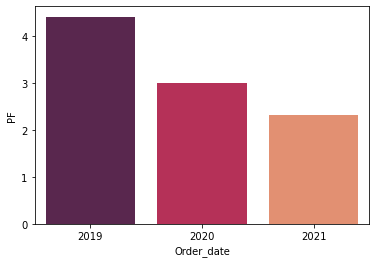

In [26]:
sns.barplot(data=PF, x='Order_date', y='PF', palette='rocket');

How has the average revenue per user changed?

In [27]:
ARPU = df_for_metrics.groupby(df_for_metrics['Order_date'].dt.year).agg({'User_ID':'nunique', 'Price':'sum'}).reset_index()
ARPU['ARPU'] = ARPU['Price'] / ARPU['User_ID']
ARPU = ARPU[['Order_date', 'ARPU']]
ARPU

,Order_date,ARPU
0,2019,1571.363445
1,2020,1032.469323
2,2021,870.589879


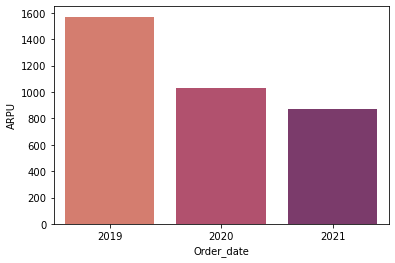

In [28]:
sns.barplot(data=ARPU, x='Order_date', y='ARPU', palette='flare');

→ Although the average order value in 2021 has increased compared with previous years, the average purchase frequency and the average revenue per user has been declining annually since 2019.

__3. Repeat Purchase Rate__

In [29]:
first_order = df.groupby('User_ID', as_index=False).agg({'Order_date':'min'}).rename(columns={'Order_date':'First_order'})

In [30]:
df = df.merge(first_order, on='User_ID')

In [34]:
df['Date_diff'] = (df['Order_date'] - df['First_order']).dt.days

In [35]:
repeat_purchase = df.loc[df['Date_diff'] > 0].groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'}) \
.rename(columns={'User_ID':'Repeat_customers'}).reset_index()

In [40]:
cohort_size = df.groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'}) \
.rename(columns={'User_ID':'Cohort_size'}).reset_index()

In [41]:
repeat_purchase_rate = cohort_size.merge(repeat_purchase, on='First_order')

In [42]:
repeat_purchase_rate['Repeat_purchase_rate'] = repeat_purchase_rate['Repeat_customers'] / repeat_purchase_rate['Cohort_size']

In [47]:
repeat_purchase_rate.head()

,First_order,Cohort_size,Repeat_customers,Repeat_purchase_rate
0,2018-12,66,53,0.803030
1,2019-01,188,126,0.670213
2,2019-02,212,138,0.650943
3,2019-03,206,125,0.606796
4,2019-04,153,97,0.633987


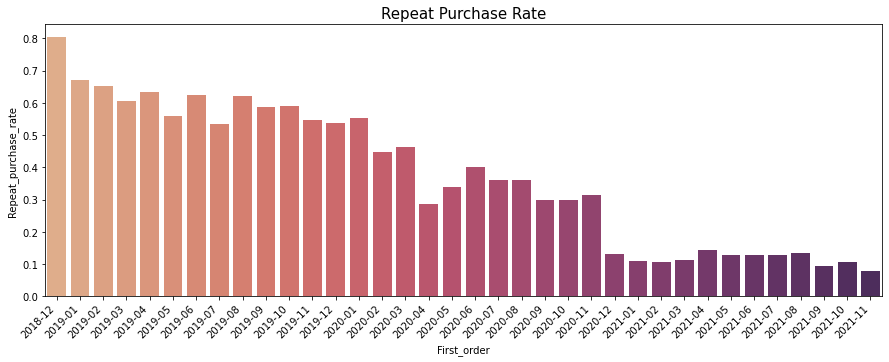

In [44]:
plt.figure(figsize=(15, 5))
sns.barplot(data=repeat_purchase_rate, x='First_order',y='Repeat_purchase_rate', palette='flare')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Repeat Purchase Rate", fontsize = 15);

→ Initially, the store had high repeat purchase rate, but it has been falling almost continuously over the given period.

Then, I'll look at cohorts size to see if there is a dependence between it and repeat purchase rate:

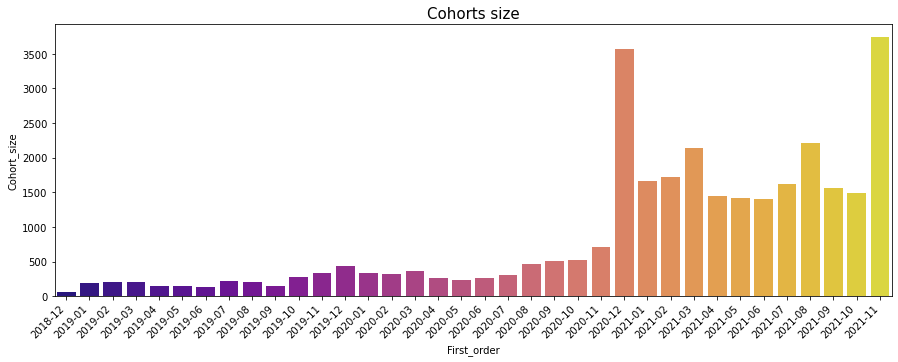

In [46]:
plt.figure(figsize=(15, 5))
sns.barplot(data=cohort_size, x='First_order', y='Cohort_size', palette='plasma')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Cohorts size", fontsize = 15);

→ Until the beginning of 2020, when cohort size didn't exceed 1000 customers, the repeat purchase rate didn't fall below 0.5, which means that >50% of users who made a purchase in the store returned to it again. However, after the number of customers started to grow rapidly, the repeat purchase rate started to fall, and in December 2021 fell below 0.1.

Let's look at the dependence of the cohort size and the repeate purchase rate on another graph:

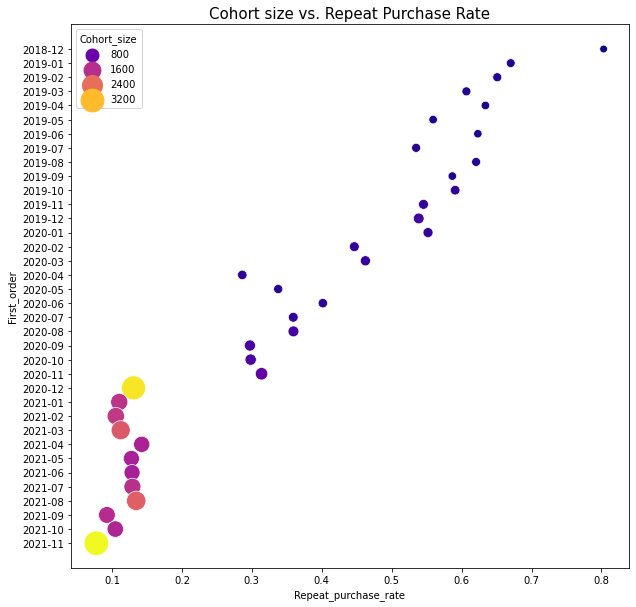

In [48]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=repeat_purchase_rate, x='Repeat_purchase_rate', y=repeat_purchase_rate.First_order.astype(str),
                hue='Cohort_size', size='Cohort_size', sizes=(60,600), legend='brief', palette='plasma');
plt.title('Cohort size vs. Repeat Purchase Rate', fontsize = 15);

→ The graph shows that the larger the cohort size, the lower the frequency of repeat purchases.

__4. Retention Rate__

Next, I’ll take a closer look at customer retention in the first year after the first purchase:

In [49]:
df['Cohort_period'] = pd.cut(df['Date_diff'], [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365, 100000], 
                             labels=['0 day', '30 d', '60 d', '90 d', '120 d', '150 d', '180 d', '210 d', '240 d', '270 d', '300 d', '330 d', '365 d', '>365 d'])

In [50]:
cohort_0 = df.query("Cohort_period=='0 day'").groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'})['User_ID']

In [51]:
cohorts = df.groupby([df['First_order'].dt.to_period('M'), 'Cohort_period']).agg({'User_ID':'nunique'}).reset_index()

In [52]:
cohorts = cohorts.loc[cohorts['Cohort_period'] != '>365 d']

In [53]:
cohorts = cohorts.pivot(index=['First_order'], columns=['Cohort_period'], values=['User_ID'])

In [54]:
cohorts = cohorts.divide(cohort_0, axis=0)

In [55]:
cohorts.columns = cohorts.columns.droplevel(0)

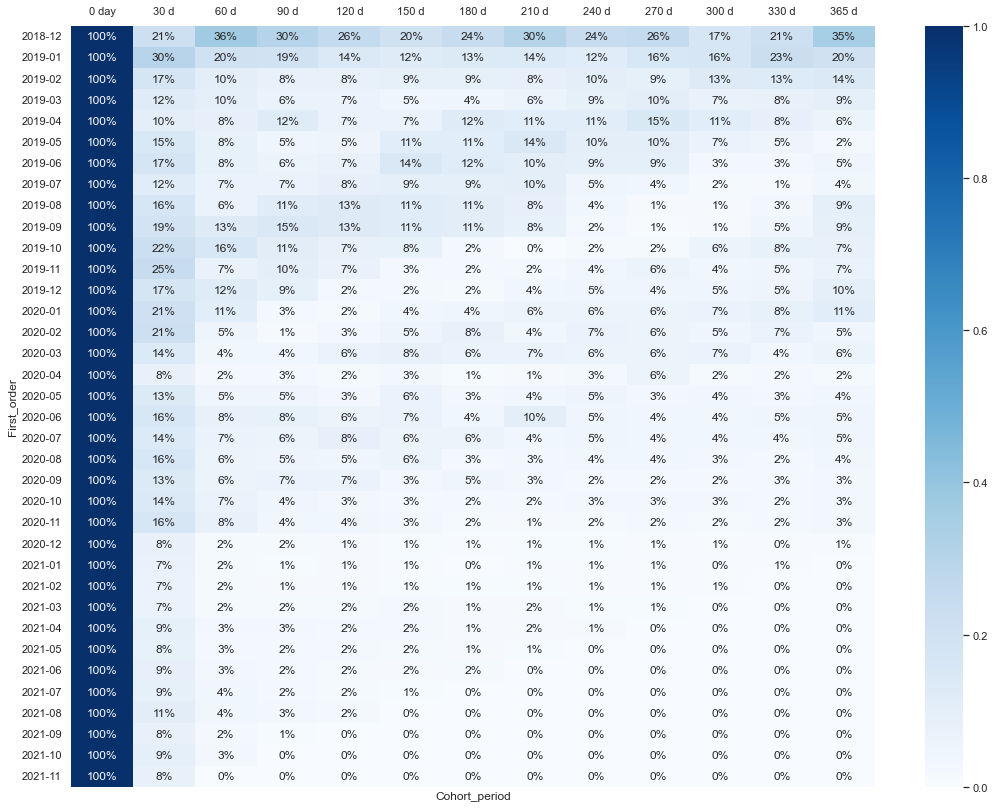

In [56]:
sns.set(style='white')
plt.figure(figsize=(18, 14))
sns.heatmap(cohorts, annot=True, fmt='.0%', cmap="Blues").tick_params(labelbottom=False,labeltop=True)

→ The graph shows that the retention rate has been falling almost continuously over a given period. If for the 2018-12 cohort the share of customers who returned in the first 30 days was 21%, for the 2021-11 cohort it was only 8%. The same way, if 35% of customers from cohort 2018-12 returned in the first year, for cohort 2020-12 it was only 1% of customers. It is most likely that the company was focused on attracting new users, hence such a dramatic increase in the number of orders, but was not engaged in retaining them.

__5. RFM analysis__

R - the amount of time since a customer’s last purchase <br />
F - the total number of customer's purchases in a given period <br />
M - the total amount of customer's purchases

In [ ]:
last_date = df['Order_date'].max()

In [ ]:
df['Days_since_order'] = (last_date - df['Order_date']).dt.days

In [ ]:
rfm_df = df.groupby('User_ID', as_index=False).agg({
                                     'Order_date': lambda x: (last_date - x.max()).days,
                                     'Order_ID': lambda x: len(x),
                                     'Price': lambda x: x.sum()})

In [ ]:
rfm_df.rename(columns={'Order_date':'Recency', 'Order_ID':'Frequency', 'Price':'Monetary'}, inplace=True)

In [ ]:
rfm_df[['Recency', 'Frequency', 'Monetary']].describe()

Converting RFM Scores to Single Variable:

In [ ]:
rfm_df['R'] = pd.cut(rfm_df['Recency'], bins=[0, 30, 200, 360, 10000], labels=[4, 3, 2, 1])

→ The nearest date gets 4 and the furthest date gets 1

In [ ]:
rfm_df['F'] = pd.cut(rfm_df['Frequency'], bins=[0, 1, 5, 15, 10000], labels=[1, 2, 3, 4])

→ The least frequency gets 1 and the maximum frequency gets 4

In [ ]:
rfm_df['M'] = pd.cut(rfm_df['Monetary'], bins=[0, 300, 1000, 5000, 1000000], labels=[1, 2, 3, 4])

→ The least money gets 1, the most money gets 4

In [ ]:
rfm_df['RFM'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)

In [ ]:
rfm_df.head()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
sns.countplot(data=rfm_df, x='R', palette='PuBuGn', ax = axes[0]);
sns.countplot(data=rfm_df, x='F', palette='PuBuGn', ax = axes[1]);
sns.countplot(data=rfm_df, x='M', palette='PuBuGn', ax = axes[2]);
plt.suptitle("Distribution of RFM", fontsize = 20);

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(11, 11))
r_range = range(1, 5)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm_df[(rfm_df['R'] == r) & (rfm_df['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 4:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=9)
        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('teal')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

→ The largest part of purchases is made by customers who place orders either rarely or even once. In addition, customers who have made only one order (F=1) have the lowest check, and regular customers (F=4) have the highest. <br />
As for the Recency score, most of the purchases were made in the period from six months to a year ago (R=2), when a large number of customers placed one-time orders (F=1) for small amounts (M=1). Perhaps, these are customers who came in December 2020, when there was a sharp rise in orders during Christmas week. <br />
The graphs also shows that the customers behaviour practically hasn't changed over time, and for each of the Recency scores the Frequency and Monetary scores were distributed approximately equally. It also suggests that the company was only focused on attracting new customers, but didn't encourage them  to repeat purchases or spend more money.

Conclusion: While maintaining the current marketing plan to bring in new customers to the store, the company should focus on increasing the product value in order to return to indicators of 2019 in terms of the average purchase frequency, the average revenue per user and the repeate purchase rate, and subsequently exceed them.